In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## 1. Import Library

In [ ]:
# --- 1. Import Libraries ---
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
import albumentations as A
import json
import os
import git
from sklearn.model_selection import train_test_split
from flask import Flask, request, jsonify
import requests
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence

## 2. Clone Dataset

In [ ]:
# Clone repository
repo_url = "https://github.com/Ezraliano/Dataset_NeoDental.git"
local_dir = "Dataset_NeoDental"
if not os.path.exists(local_dir):
    git.Repo.clone_from(repo_url, local_dir)

In [ ]:
# Define DEST_DIR
DEST_DIR = "Dataset_NeoDental"  # Replace with the desired directory path

# Create folder structure of destination dataset
os.makedirs(os.path.join(DEST_DIR, "train", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "train", "labels"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "val", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "val", "labels"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "test", "images"), exist_ok=True)
os.makedirs(os.path.join(DEST_DIR, "test", "labels"), exist_ok=True)

In [ ]:
# Load metadata dan mapping kelas
SRC_DIR = "Dataset_NeoDental"
meta = json.load(open(os.path.join(SRC_DIR, "meta.json")))
classes = {entry["title"]: index for index, entry in enumerate(meta["classes"])}

In [ ]:
def polygon_to_mask(annotation, image_shape, class_map):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for obj in annotation['objects']:
        class_title = obj['classTitle']
        if class_title not in class_map:
            print(f"Kelas '{class_title}' tidak ditemukan dalam mapping. Objek diabaikan.")
            continue  # Skip kelas yang tidak valid

        # Pastikan struktur points valid
        if 'points' not in obj or 'exterior' not in obj['points'] or len(obj['points']['exterior']) < 1:
            print(f"Objek {obj['id']} tidak memiliki polygon valid. Objek diabaikan.")
            continue

        # Ambil titik exterior dan pastikan bertipe integer
        try:
            polygon = np.array(obj['points']['exterior'], dtype=np.int32)
        except:
            print(f"Koordinat polygon pada objek {obj['id']} tidak valid. Objek diabaikan.")
            continue

        # Pastikan jumlah titik cukup untuk poligon (min 3 titik)
        if len(polygon) < 3:
            print(f"Poligon pada objek {obj['id']} tidak valid (kurang dari 3 titik). Objek diabaikan.")
            continue

        # Gambar poligon ke mask
        cv2.fillPoly(mask, [polygon], color=class_map[class_title])

    return mask

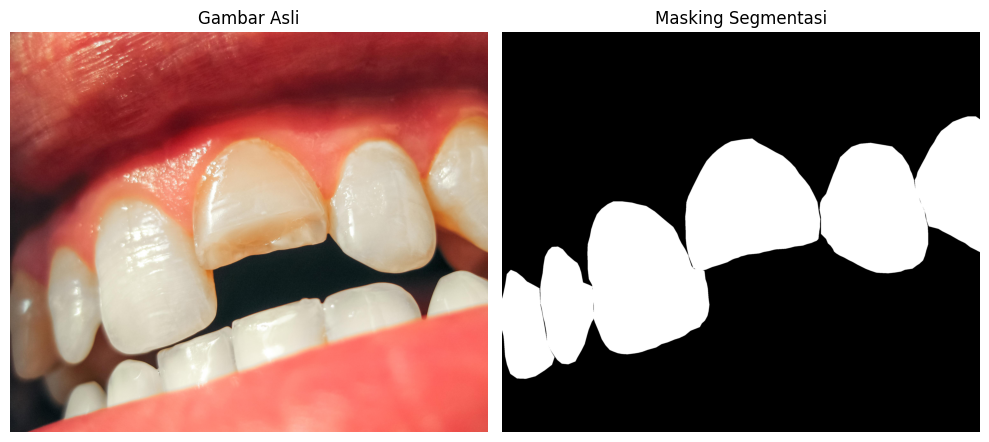

In [ ]:
# Cari file gambar dan anotasi yang cocok
img_dir = os.path.join(SRC_DIR, "train", "img")
ann_dir = os.path.join(SRC_DIR, "train", "ann")

# Ambil salah satu file sebagai contoh
img_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]
if not img_files:
    raise Exception("Tidak ada file gambar ditemukan!")

img_filename = img_files[0]
img_path = os.path.join(img_dir, img_filename)
ann_path = os.path.join(ann_dir, img_filename + ".json")

# Pastikan file JSON ada
if not os.path.exists(ann_path):
    raise FileNotFoundError(f"File anotasi tidak ditemukan: {ann_path}")

# Load gambar dan anotasi
image = cv2.imread(img_path)
with open(ann_path, 'r') as f:
    annotation = json.load(f)

# Buat mask
mask = polygon_to_mask(annotation, image.shape, classes)

# Tampilkan hasil
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Gambar Asli")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.title("Masking Segmentasi")
plt.axis("off")
plt.tight_layout()
plt.show()

## 3. Expolrasi Data Analysis

In [ ]:
img_dir = os.path.join(SRC_DIR, "train", "img")
ann_dir = os.path.join(SRC_DIR, "train", "ann")

img_files = sorted([f for f in os.listdir(img_dir) if f.endswith('.jpg')])
ann_files = sorted([f for f in os.listdir(ann_dir) if f.endswith('.json')])

print(f"Jumlah gambar: {len(img_files)}")
print(f"Jumlah anotasi: {len(ann_files)}")

missing_anns = [f for f in img_files if f + ".json" not in ann_files]
print(f"Gambar tanpa anotasi: {len(missing_anns)}")


Jumlah gambar: 1991
Jumlah anotasi: 1991
Gambar tanpa anotasi: 0


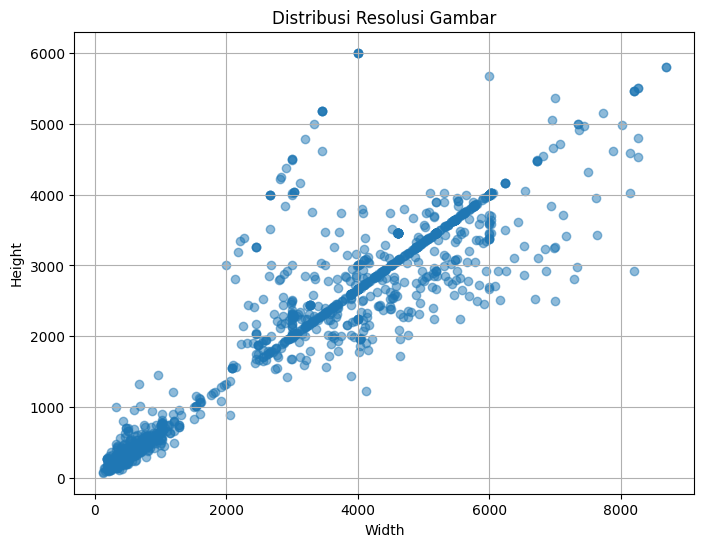

In [ ]:
sizes = []
for file in img_files:
    path = os.path.join(img_dir, file)
    img = cv2.imread(path)
    if img is not None:
        h, w = img.shape[:2]
        sizes.append((w, h))

sizes_arr = np.array(sizes)
plt.figure(figsize=(8, 6))
plt.scatter(sizes_arr[:, 0], sizes_arr[:, 1], alpha=0.5)
plt.xlabel("Width")
plt.ylabel("Height")
plt.title("Distribusi Resolusi Gambar")
plt.grid(True)
plt.show()


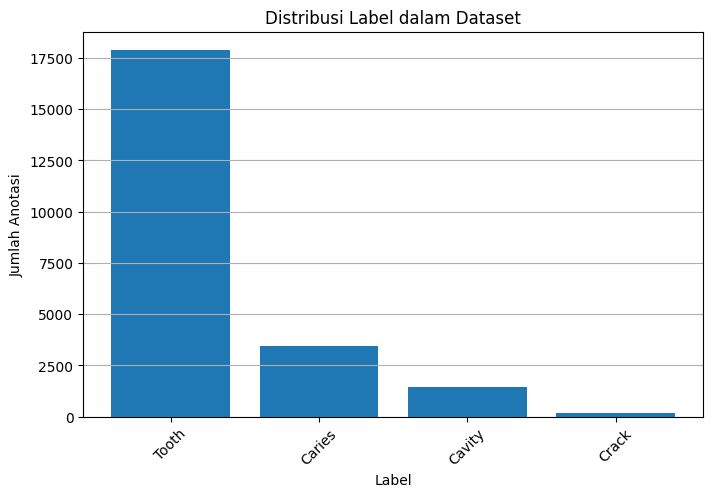

Distribusi kelas:
Tooth: 17884 objek
Caries: 3451 objek
Cavity: 1452 objek
Crack: 150 objek


In [ ]:
from collections import Counter

label_counts = Counter()

for ann_file in ann_files:
    path = os.path.join(ann_dir, ann_file)
    with open(path, 'r') as f:
        data = json.load(f)
        for obj in data["objects"]:
            label_counts[obj["classTitle"]] += 1

# Visualisasi
plt.figure(figsize=(8, 5))
plt.bar(label_counts.keys(), label_counts.values())
plt.title("Distribusi Label dalam Dataset")
plt.ylabel("Jumlah Anotasi")
plt.xlabel("Label")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()

print("Distribusi kelas:")
for label, count in label_counts.items():
    print(f"{label}: {count} objek")


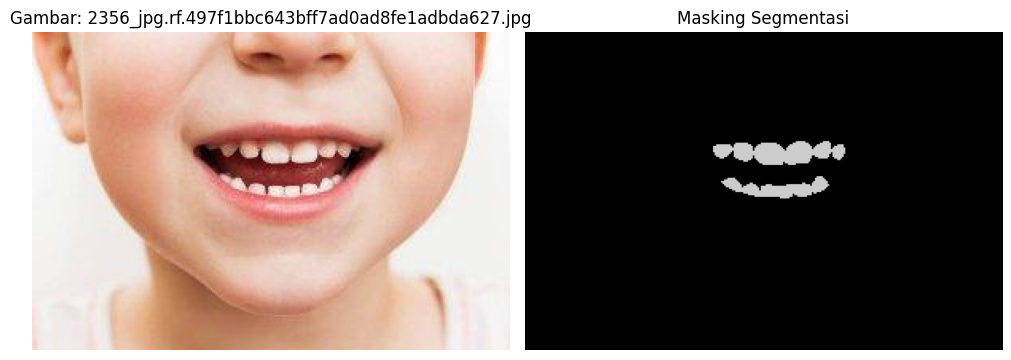

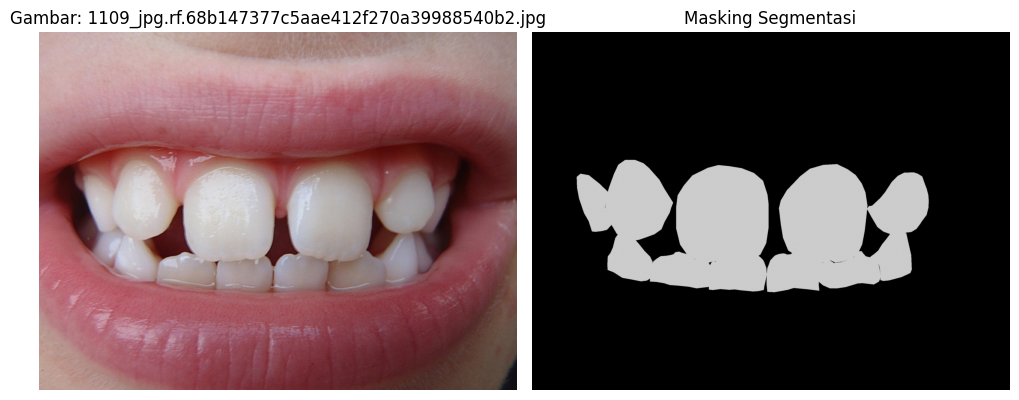

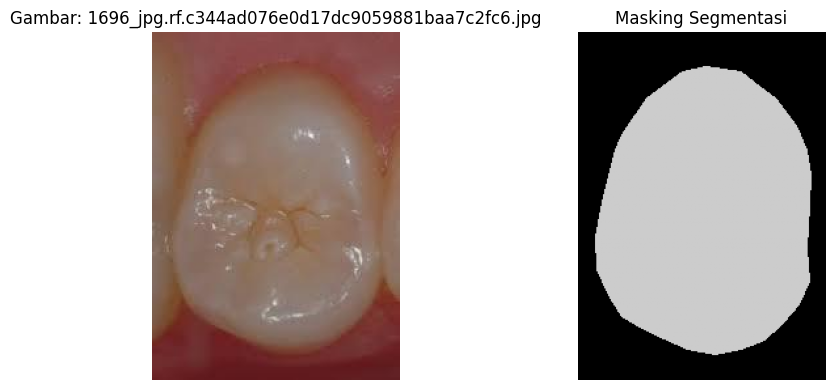

In [ ]:
import random

n_samples = 3
sample_imgs = random.sample(img_files, n_samples)

for img_file in sample_imgs:
    img_path = os.path.join(img_dir, img_file)
    ann_path = os.path.join(ann_dir, img_file + ".json")

    image = cv2.imread(img_path)
    with open(ann_path, 'r') as f:
        annotation = json.load(f)

    mask = polygon_to_mask(annotation, image.shape, classes)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(f"Gambar: {img_file}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='nipy_spectral')
    plt.title("Masking Segmentasi")
    plt.axis("off")
    plt.tight_layout()
    plt.show()


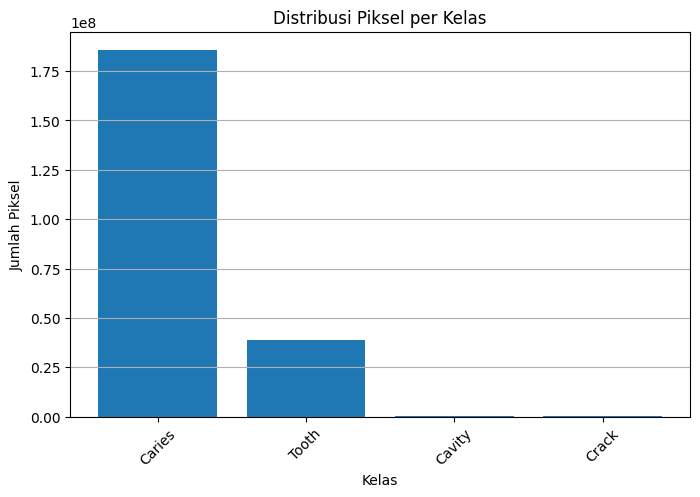

In [ ]:
pixel_distribution = Counter()

for img_file in img_files[:20]:  # Gunakan subset jika data besar
    img_path = os.path.join(img_dir, img_file)
    ann_path = os.path.join(ann_dir, img_file + ".json")

    if os.path.exists(ann_path):
        image = cv2.imread(img_path)
        with open(ann_path, 'r') as f:
            annotation = json.load(f)
        mask = polygon_to_mask(annotation, image.shape, classes)

        for cls_id in np.unique(mask):
            pixel_distribution[cls_id] += np.sum(mask == cls_id)

# Tampilkan hasil
label_map_inv = {v: k for k, v in classes.items()}
labels = [label_map_inv[c] for c in pixel_distribution.keys()]
pixels = pixel_distribution.values()

plt.figure(figsize=(8, 5))
plt.bar(labels, pixels)
plt.title("Distribusi Piksel per Kelas")
plt.ylabel("Jumlah Piksel")
plt.xlabel("Kelas")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.show()


## 4. Data Prepocessing

In [ ]:
IMG_SIZE = 256  # Ukuran yang akan digunakan untuk U-Net


def preprocess_mask(mask_path, class_map):
    with open(mask_path, 'r') as f:
        annotation = json.load(f)

    base_filename = os.path.splitext(os.path.basename(mask_path))[0]
    image_path = os.path.join(os.path.dirname(mask_path).replace("ann", "img"), base_filename)

    if not os.path.exists(image_path):
        print(f"Warning: Image file not found: {image_path}")
        return None

    original_image = cv2.imread(image_path)
    original_shape = original_image.shape

    mask = polygon_to_mask(annotation, original_shape, class_map)
    mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_NEAREST)

    # --- One-hot encoding ---
    num_classes = len(class_map)
    mask_onehot = np.zeros((IMG_SIZE, IMG_SIZE, num_classes), dtype=np.float32)
    for class_id in range(num_classes):
        mask_onehot[:, :, class_id] = (mask == class_id).astype(np.float32)

    return mask_onehot

In [ ]:
from sklearn.model_selection import train_test_split

# Buat list file
img_files = sorted([f for f in os.listdir(img_dir) if f.endswith(".jpg")])
ann_files = [f + ".json" for f in img_files if os.path.exists(os.path.join(ann_dir, f + ".json"))]

# Pastikan hanya pasangan yang valid
img_paths = [os.path.join(img_dir, f) for f in img_files if f + ".json" in ann_files]
mask_paths = [os.path.join(ann_dir, f + ".json") for f in img_files if f + ".json" in ann_files]

# Split
train_imgs, val_imgs, train_masks, val_masks = train_test_split(img_paths, mask_paths, test_size=0.2, random_state=42)

print(f"Train: {len(train_imgs)}, Val: {len(val_imgs)}")


Train: 1592, Val: 399


In [ ]:
from tensorflow.keras.utils import Sequence

class DentalDataset(Sequence):
    def __init__(self, image_paths, mask_paths, class_map, batch_size=8, augment=None):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.class_map = class_map
        self.batch_size = batch_size
        self.augment = augment

    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))

    def __getitem__(self, idx):
        batch_x = self.image_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_y = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []
        for img_path, mask_path in zip(batch_x, batch_y):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path, self.class_map)
            if mask is None:
                continue
            if self.augment:
                augmented = self.augment(image=img, mask=mask)
                img = augmented["image"]
                mask = augmented["mask"]
            images.append(img)
            masks.append(mask)
        return np.array(images), np.array(masks)


In [ ]:
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0  # Normalisasi ke [0,1]
    return img


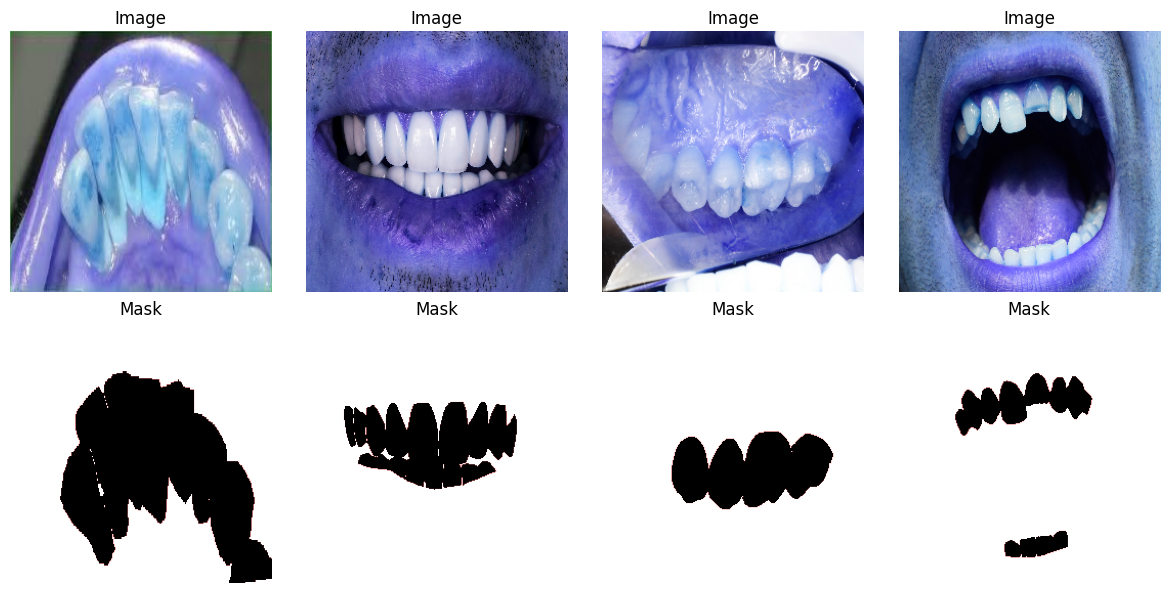

In [ ]:
train_dataset = DentalDataset(train_imgs, train_masks, classes, batch_size=4)
val_dataset = DentalDataset(val_imgs, val_masks, classes, batch_size=4)

# Ambil satu batch untuk cek
sample_imgs, sample_masks = train_dataset[0]

plt.figure(figsize=(12, 6))
for i in range(4):
    plt.subplot(2, 4, i + 1)
    plt.imshow(sample_imgs[i])
    plt.axis("off")
    plt.title("Image")
    plt.subplot(2, 4, i + 5)
    plt.imshow(sample_masks[i].squeeze(), cmap='gray')
    plt.axis("off")
    plt.title("Mask")
plt.tight_layout()
plt.show()


## 5.  Modeling

In [ ]:
from tensorflow.keras import layers, Model
import tensorflow.keras as keras

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = layers.Input(input_size)

    def conv_block(x, filters):
        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        x = layers.Conv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.Activation('relu')(x)

        return x

    # Encoder
    c1 = conv_block(inputs, 64)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = conv_block(p1, 128)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = conv_block(p2, 256)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    c4 = conv_block(p3, 512)
    p4 = layers.MaxPooling2D((2, 2))(c4)

    c5 = conv_block(p4, 1024)

    # Decoder
    u6 = layers.Conv2DTranspose(512, 2, strides=2, padding='same')(c5)
    u6 = layers.concatenate([u6, c4])
    c6 = conv_block(u6, 512)

    u7 = layers.Conv2DTranspose(256, 2, strides=2, padding='same')(c6)
    u7 = layers.concatenate([u7, c3])
    c7 = conv_block(u7, 256)

    u8 = layers.Conv2DTranspose(128, 2, strides=2, padding='same')(c7)
    u8 = layers.concatenate([u8, c2])
    c8 = conv_block(u8, 128)

    u9 = layers.Conv2DTranspose(64, 2, strides=2, padding='same')(c8)
    u9 = layers.concatenate([u9, c1])
    c9 = conv_block(u9, 64)

    # Opsi: Tambahkan satu atau dua Conv layer sebelum output
    c9 = layers.Conv2D(64, 3, activation='relu', padding='same')(c9)
    c9 = layers.BatchNormalization()(c9)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(c9)

    return Model(inputs=[inputs], outputs=[outputs])

In [ ]:
import tensorflow.keras.backend as K

# Define the Dice coefficient function
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    """
    Calculates the Dice Coefficient.
    Args:
        y_true: Ground truth masks (one-hot encoded).
        y_pred: Predicted masks (output of softmax).
        smooth: Smoothing factor to prevent division by zero.
    Returns:
        Dice coefficient.
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# --- LOSS FUNCTION: WEIGHTED CROSS ENTROPY ---
def weighted_categorical_crossentropy(weights):
    weights = K.variable(weights)
    def loss(y_true, y_pred):
        y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        return -K.sum(y_true * K.log(y_pred) * weights, axis=-1)
    return loss

def combined_dice_ce_loss(class_weights):
    ce = weighted_categorical_crossentropy(class_weights)

    def loss(y_true, y_pred):
        # Dice coefficient calculation here uses the defined function
        dice = 1 - dice_coefficient(y_true, y_pred)
        return ce(y_true, y_pred) + dice
    return loss

In [ ]:
# --- DEFINE MODEL ---
model = unet_model(input_size=(256, 256, 3), num_classes=4)

# --- DEFINE CLASS WEIGHTS (adjust as needed) ---
class_weights = np.array([1.0, 1.0, 3.5, 5.0])  # [tooth, caries, cavity, crack]

# --- COMPILE MODEL ---
model.compile(
    optimizer='adam',
    loss=weighted_categorical_crossentropy(class_weights),
    metrics=['accuracy']
)


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint_cb = ModelCheckpoint("unet_best_model.keras", save_best_only=True, monitor='val_loss', mode='min')
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
EPOCHS = 45
BATCH_SIZE = 8

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=[checkpoint_cb, earlystop_cb]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/45


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


398/398 ━━━━━━━━━━━━━━━━━━━━ 245s 481ms/step - accuracy: 0.7000 - loss: 1.3147 - val_accuracy: 0.6887 - val_loss: 1.5208
Epoch 2/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 181s 454ms/step - accuracy: 0.8309 - loss: 0.6776 - val_accuracy: 0.8063 - val_loss: 0.8179
Epoch 3/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 180s 450ms/step - accuracy: 0.8521 - loss: 0.5925 - val_accuracy: 0.8550 - val_loss: 0.8890
Epoch 4/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 187s 471ms/step - accuracy: 0.8573 - loss: 0.5883 - val_accuracy: 0.7792 - val_loss: 0.7784
Epoch 5/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 195s 454ms/step - accuracy: 0.8786 - loss: 0.5273 - val_accuracy: 0.8848 - val_loss: 0.5549
Epoch 6/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 174s 436ms/step - accuracy: 0.8846 - loss: 0.4793 - val_accuracy: 0.8411 - val_loss: 0.6055
Epoch 7/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 177s 443ms/step - accuracy: 0.8957 - loss: 0.4427 - val_accuracy: 0.8791 - val_loss: 0.6381
Epoch 8/45
398/398 ━━━━━━━━━━━━━━━━━━━━ 182s 458ms/step - accuracy: 0.9036 - loss: 0.41

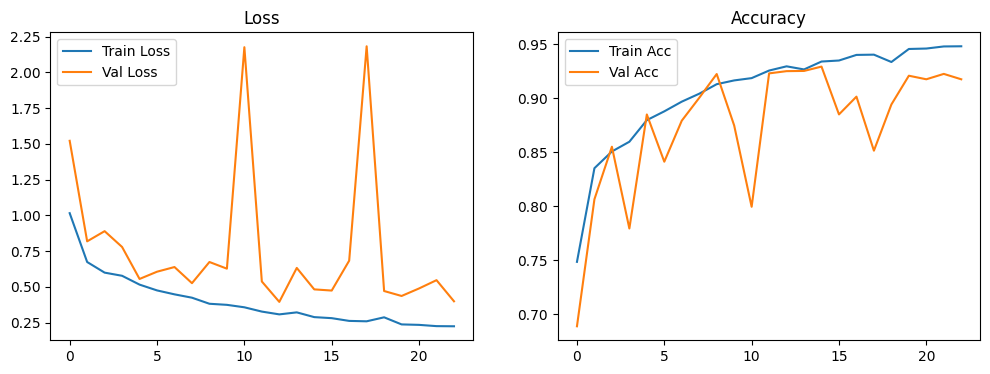

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()
plt.show()


## 6. Evaluasi

In [ ]:

# Compile ulang
model.compile(
    optimizer='adam',
    loss=combined_dice_ce_loss(class_weights), # Use the combined loss - Corrected typo
    metrics=['accuracy'] # Accuracy is a common metric, you might consider others for segmentation
)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_70']
Received: inputs=Tensor(shape=(4, 256, 256, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


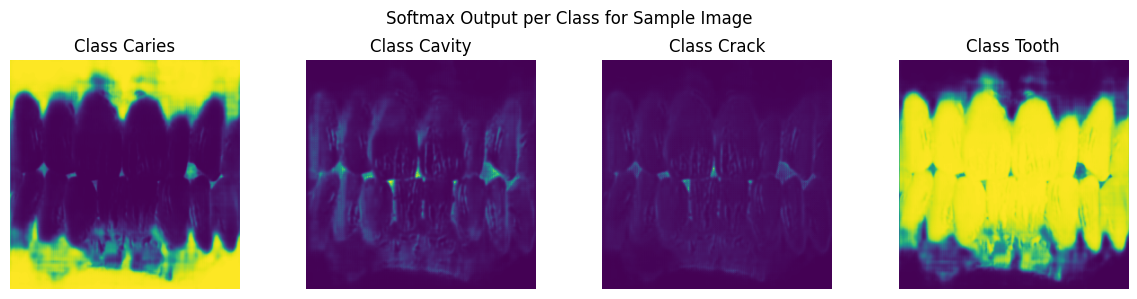

In [ ]:
# Ambil satu batch dari validation dataset
X_val_sample, Y_val_sample = val_dataset[0]

# Lakukan prediksi menggunakan model
Y_pred = model.predict(X_val_sample)

plt.figure(figsize=(12, 3))
# Plot the predictions for the first image in the sample batch
# Y_pred[0, :, :, c] represents the probability map for class 'c' for the first image in the batch
for c in range(4):
    plt.subplot(1, 4, c+1)
    # Use the probability map for visualization
    plt.imshow(Y_pred[0, :, :, c], cmap="viridis")
    # Use class names for clarity in titles
    plt.title(f"Class {list(classes.keys())[list(classes.values()).index(c)]}")
    plt.axis("off")
plt.suptitle("Softmax Output per Class for Sample Image")
plt.tight_layout()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


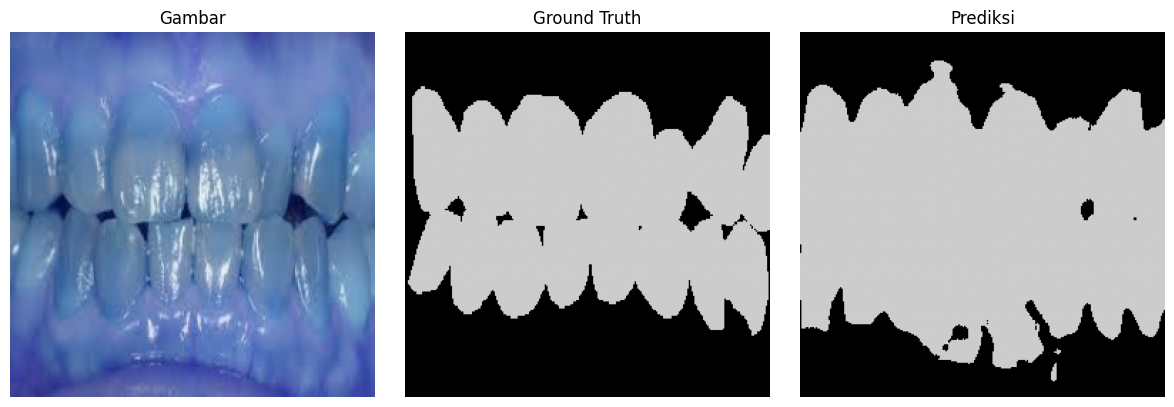

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


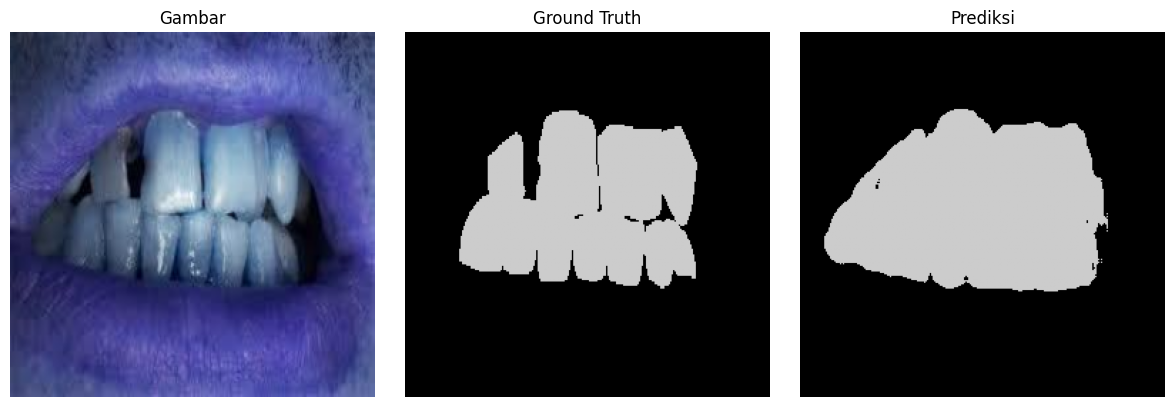

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


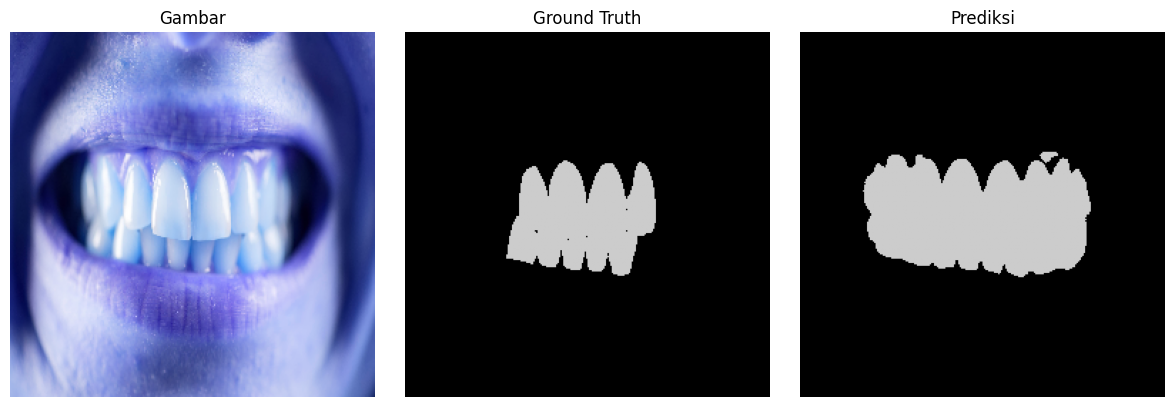

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


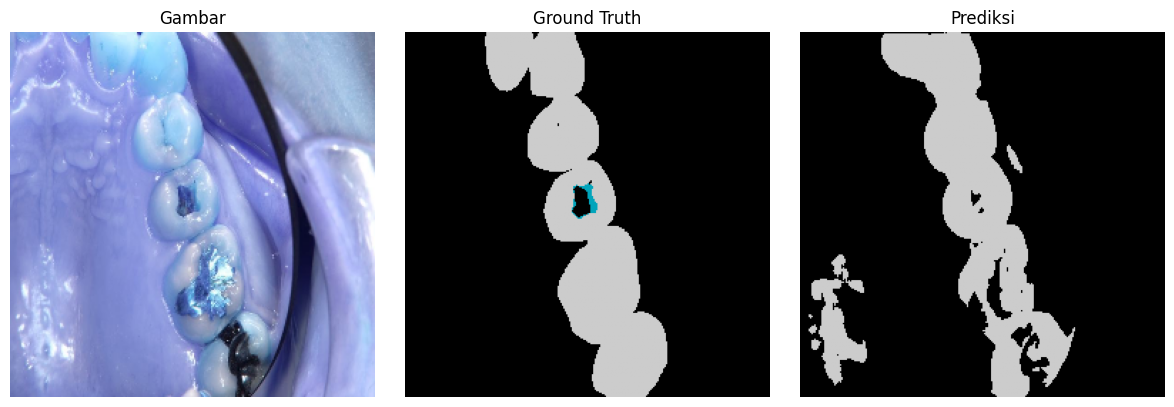

In [ ]:
# Ambil sample dari val_dataset
X_val_batch, Y_val_batch = val_dataset[0]  # satu batch

# Loop melalui setiap gambar dalam batch
for i in range(X_val_batch.shape[0]):
    # Get the i-th image and ground truth mask from the batch
    X_val_sample = X_val_batch[i]  # Shape (256, 256, 3)
    Y_true_sample = Y_val_batch[i] # Shape (256, 256, 4)

    # Add batch dimension for prediction
    X_val_input = X_val_sample[np.newaxis, ...]  # Shape (1, 256, 256, 3)

    # Predict segmentation for the single image
    Y_pred_probs = model.predict(X_val_input)[0]  # Shape (256, 256, 4)
    # print("Max probability per class:", Y_pred_probs.max(axis=(0, 1))) # Optional print

    # Predict the class for each pixel
    Y_pred_class = np.argmax(Y_pred_probs, axis=-1)  # Shape (256, 256)

    # Ground truth (convert one-hot mask to class index mask)
    Y_true_class = np.argmax(Y_true_sample, axis=-1) # Shape (256, 256)


    # Visualisasi
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(X_val_sample) # Plot the single image
    plt.title("Gambar")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(Y_true_class, cmap='nipy_spectral') # Plot the single ground truth mask
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(Y_pred_class, cmap='nipy_spectral') # Plot the single predicted mask
    plt.title("Prediksi")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## 7. Inference

Saving 3444_jpg.rf.1d604c2b5bffa2859008a717e0038391.jpg to 3444_jpg.rf.1d604c2b5bffa2859008a717e0038391.jpg
Gambar '3444_jpg.rf.1d604c2b5bffa2859008a717e0038391.jpg' berhasil diunggah.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


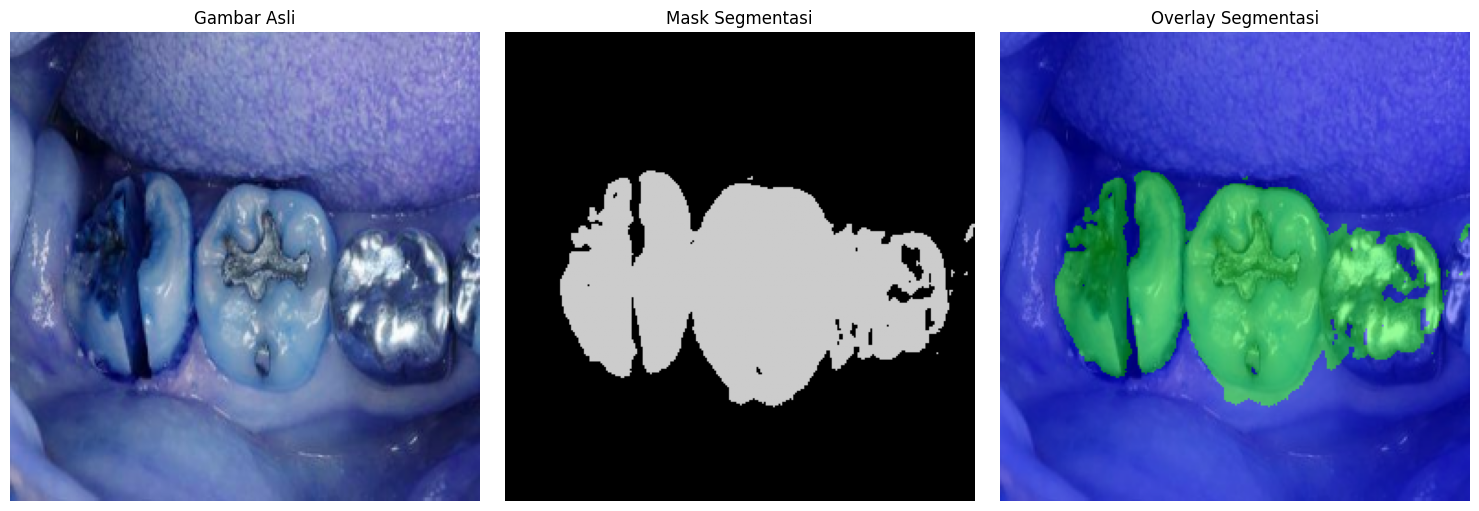

Persentase area per kelas:
 - Caries    : 73.74%
 - Tooth     : 26.26%


In [ ]:
from google.colab import files
from PIL import Image
import io

# Upload gambar dari lokal
uploaded = files.upload()
img_path = None

for filename in uploaded.keys():
    img_path = filename
    print(f"Gambar '{img_path}' berhasil diunggah.")

def inference_image(img_path, model, class_map, img_size=256, show=True):
    # 1. Preprocess gambar
    image = preprocess_image(img_path)
    input_img = np.expand_dims(image, axis=0)

    # 2. Prediksi segmentasi
    pred_mask = model.predict(input_img)[0]
    pred_class = np.argmax(pred_mask, axis=-1)

    # 3. Hitung proporsi (%) area tiap kelas
    total_pixels = pred_class.size
    unique, counts = np.unique(pred_class, return_counts=True)
    class_percentages = {
        list(class_map.keys())[list(class_map.values()).index(cls_id)]: (cnt / total_pixels) * 100
        for cls_id, cnt in zip(unique, counts)
    }

    # 4. Tampilkan visualisasi
    if show:
        plt.figure(figsize=(15, 5))

        # Gambar asli
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Gambar Asli")
        plt.axis("off")

        # Hasil prediksi (mask kelas)
        plt.subplot(1, 3, 2)
        plt.imshow(pred_class, cmap='nipy_spectral')
        plt.title("Mask Segmentasi")
        plt.axis("off")

        # Overlay di atas gambar asli (warna transparan)
        color_mask = np.zeros_like(image)
        # Map warna RGB untuk tiap kelas
        colors = {
            0: (0, 0, 255),    # Tooth - Blue
            1: (255, 0, 0),    # Caries - Red
            2: (255, 255, 0),  # Cavity - Yellow
            3: (0, 255, 0),    # Crack - Green
        }
        for class_id in np.unique(pred_class):
            color_mask[pred_class == class_id] = colors[class_id]

        overlay = (0.6 * image * 255 + 0.4 * color_mask).astype(np.uint8)
        plt.subplot(1, 3, 3)
        plt.imshow(overlay)
        plt.title("Overlay Segmentasi")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

    # 5. Print informasi persentase area
    print("Persentase area per kelas:")
    for cls, pct in class_percentages.items():
        print(f" - {cls:<10}: {pct:.2f}%")

    return pred_class, class_percentages

# Panggil inferensi
if img_path:
    pred_mask, class_percent = inference_image(img_path, model, classes)


In [ ]:
# Simpan model ke file HDF5
model.save("unet_dental_segmentation.h5")
